In [40]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [21]:
# make device agnostic

In [41]:
def load_data(dir_name: str):
    data = list()
    with open(dir_name, "r") as f:
        [data.append(np.array(line.split(","), dtype=np.float32)) for line in f]
    data = np.asarray(data)
    return data[:,1:], data[:,0] # X, y

In [126]:
X_train, Y_train = load_data("data/mnist_train.csv")
X_test, Y_test = load_data("data/mnist_test.csv")

# rescale 0-255 to 0.0-1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encoding
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size), Y_train.astype(int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size), Y_test.astype(int)] = 1.0

In [108]:
# become one with the data - karpathy
print(f"Training set size: {X_train.shape[0]}x{X_train.shape[1]}")
print(f"Testing set size: {X_test.shape[0]}x{X_test.shape[1]}")

Training set size: 60000x784
Testing set size: 10000x784


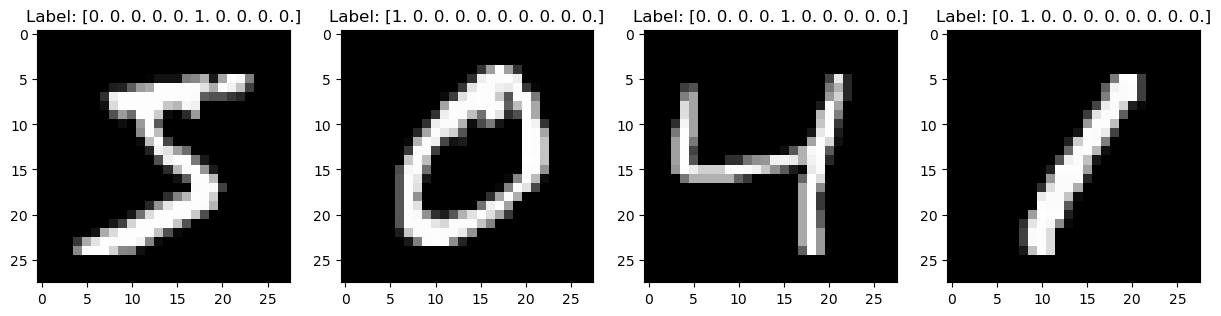

In [109]:
fig, axes = plt.subplots(1, 4, figsize=(15,10))
for image, label, ax in zip(X_train[:4], y_train[:4], axes):
    ax.imshow(image.reshape(28,28), cmap="gray", vmin=0, vmax=1.0)
    ax.set_title(f"Label: {label}")
plt.show()

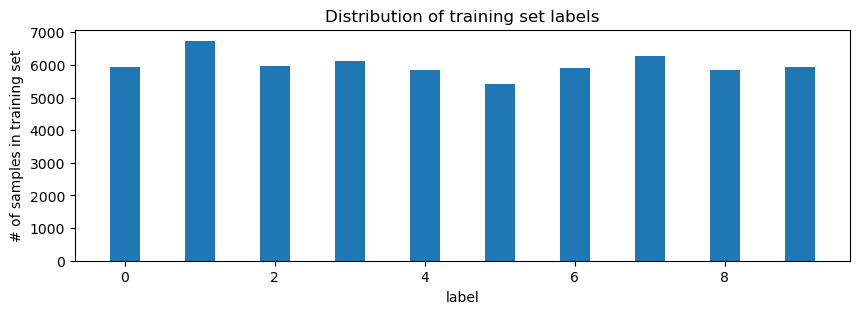

In [110]:
# distribution of labels 0-9
dist = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
for y in Y_train:
    dist[int(y)]+=1
    
plt.figure(figsize=(10, 3))
plt.bar(dist.keys(), dist.values(), width=0.4, label="Label distribution")
plt.xlabel("label")
plt.ylabel("# of samples in training set")
plt.title("Distribution of training set labels")
plt.show()

In [115]:
class MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(784, 128)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(128, 10)
        self.act_output = nn.Sigmoid()
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.act1(self.h1(X))
        X = self.act_output(self.output(X))
        return X

In [151]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

TypeError: expected np.ndarray (got Tensor)

In [192]:
torch.manual_seed(69)

model = MNIST()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 10
batch_size = 32

losses = []

In [193]:
for epoch in (t := trange(epochs)):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        out = model.forward(X_train)
        optim.zero_grad()
        loss = loss_fn(out, y_train)
        
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().numpy())
        t.set_description(f"loss: {loss:.2f}")

loss: 1.52:   0%|                                                                                                                        | 0/10 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [170]:
def onehot_to_eval(arr):   
    max_index = 0
    max_val = arr[0]
    
    for i in range(1, len(arr)):
        if arr[i] > max_val:
            max_val = arr[i]
            max_index = i
    
    return max_index#, max_val.detach().numpy()

def accuracy(y_pred, y):
    return np.sum(y_pred == y) / len(y)

In [171]:
y_pred = model(X_test)
y_pred = [onehot_to_eval(y) for y in y_pred]

acc = accuracy(y_pred[:][0], Y_test)
print(acc)

0.0974


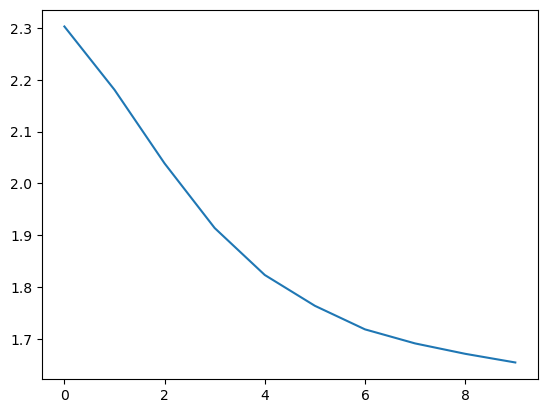

In [191]:
# plot model loss and accuracy
plt.plot(losses)
plt.show()

In [61]:
# save model